# 1. Import the Data

In [1]:
FremontBridge <- read.csv("FremontBridge.csv", header=TRUE)
str(FremontBridge)

'data.frame':	29880 obs. of  3 variables:
 $ Date                        : chr  "10/03/2012 12:00:00 AM" "10/03/2012 01:00:00 AM" "10/03/2012 02:00:00 AM" "10/03/2012 03:00:00 AM" ...
 $ Fremont.Bridge.West.Sidewalk: int  4 4 1 2 6 21 105 257 291 172 ...
 $ Fremont.Bridge.East.Sidewalk: int  9 6 1 3 1 10 50 95 146 104 ...


There are 29880 observations and 3 variables.

# 2. Clean the Data

## (a)

In [2]:
FremontBridge$Date <- as.POSIXct(strptime(FremontBridge$Date,"%m/%d/%Y %I:%M:%S %p", tz = "PST8PDT")) # in Seattle
FremontBridge$Weekday<- weekdays(FremontBridge$Date)
FremontBridge$Weekday<- as.Date(FremontBridge$Date)

## (b)

In [3]:
FremontBridge$East <- FremontBridge$Fremont.Bridge.East.Sidewalk
FremontBridge$West <- FremontBridge$Fremont.Bridge.West.Sidewalk
FremontBridge$East[is.na(FremontBridge$East)] <- as.integer(0)
FremontBridge$West[is.na(FremontBridge$West)] <- as.integer(0)

FremontBridge$Total <- FremontBridge$East + FremontBridge$West

## (c)

In [4]:
FremontBridge$hour <- format(FremontBridge$Date, "%H")
FremontBridge$dates <- as.Date(FremontBridge$Date, tz = "PST8PDT")
FremontBridge$week <- as.Date(cut(FremontBridge$Date, breaks = "week", start.on.monday = TRUE)) # weekly break point to Monday (default)
FremontBridge$month <- as.Date(cut(FremontBridge$Date,breaks = "month"))

# 3. Visualize the Data

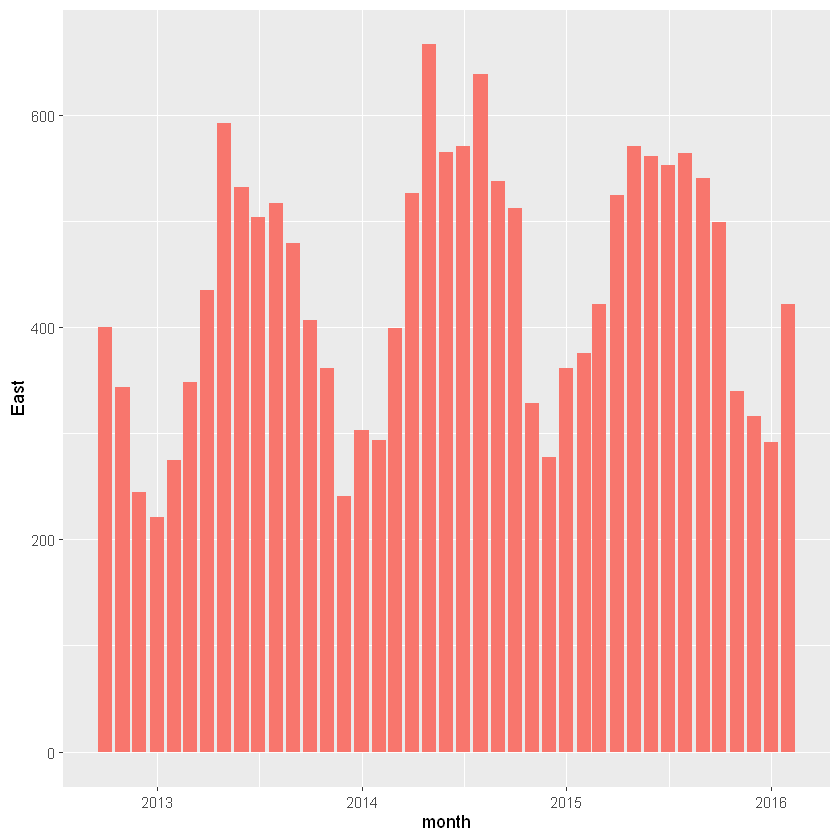

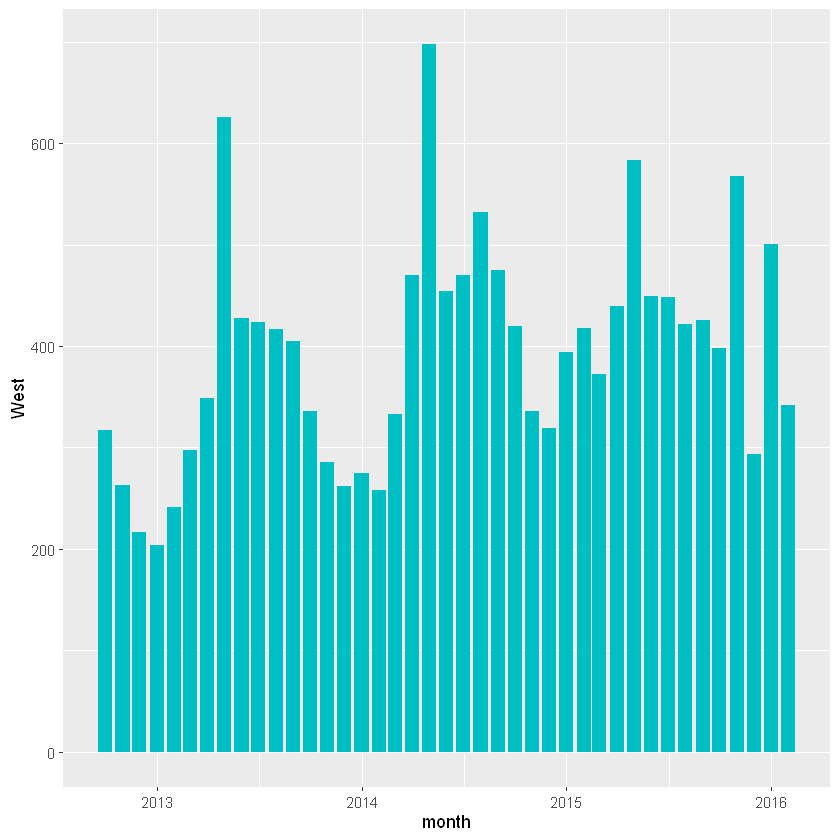

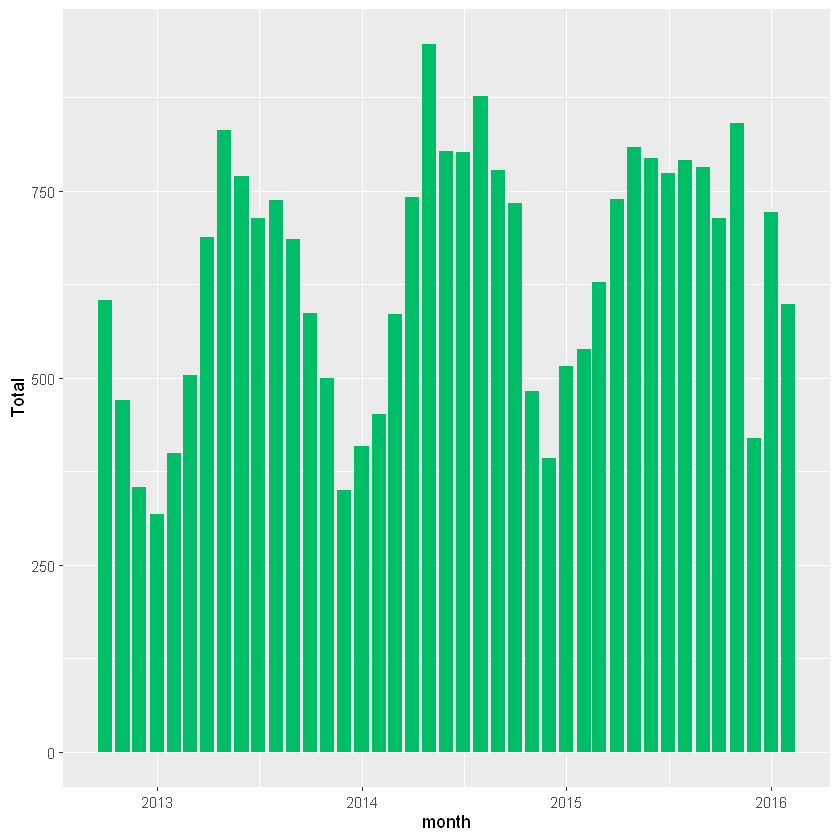

In [5]:
library(ggplot2)
library(scales)

ggplot_palette = hue_pal()(8)
red = ggplot_palette[1]
blue = ggplot_palette[5]
green = ggplot_palette[4]

ggplot(data = FremontBridge, aes(x = month, y = East)) +
  stat_summary(fun = max, geom = "bar", fill=red)
ggplot(data = FremontBridge, aes(x = month, y = West)) +
  stat_summary(fun = max, geom = "bar", fill = blue)
ggplot(data = FremontBridge, aes(x = month, y = Total)) +
  stat_summary(fun = max, geom = "bar", fill = green)

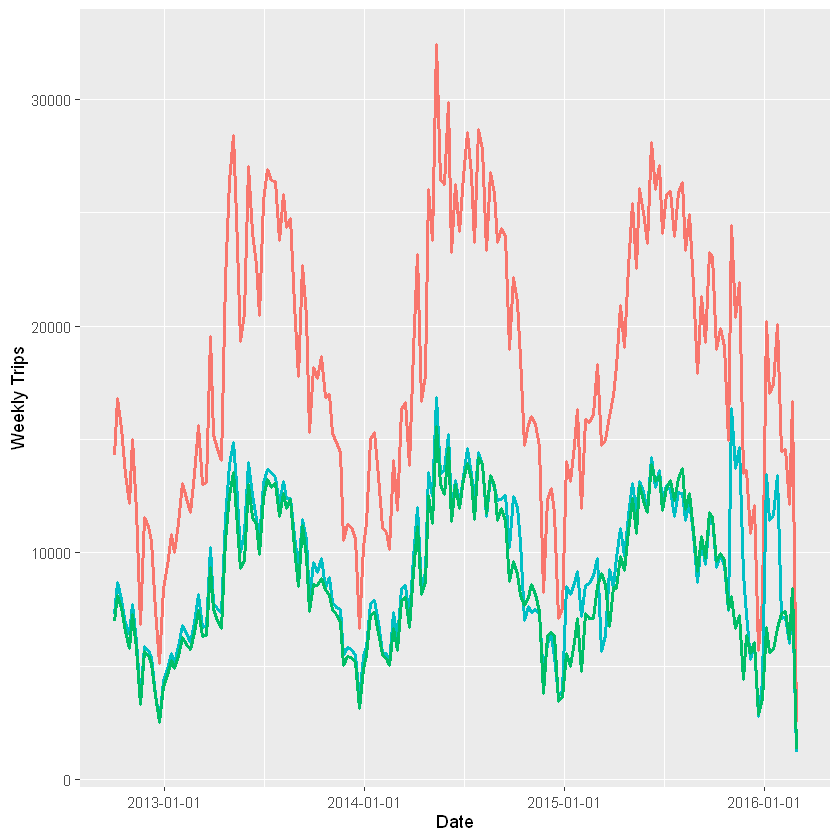

In [6]:
ggplot(FremontBridge) + stat_summary(aes(x=week, y=Total), fun = sum, geom = "line", color = red, linewidth=1) +
    stat_summary(aes(x=week,y=West), fun = sum, geom = "line", color = blue, linewidth=1) +
    stat_summary(aes(x=week,y=East), fun = sum, geom = "line", color = green, linewidth=1) +
    scale_x_date(breaks = date_breaks(width = "1 year")) + xlab("Date") + ylab("Weekly Trips")

# 4. Prepare the Data for ML

In [7]:
FremontBridgePivot <- read.csv("FremontBridgePivotnoTotals.csv", header=TRUE)
FremontBridgePivot$date <- as.POSIXct(strptime(FremontBridgePivot$date,"%m/%d/%Y", tz = "PST8PDT")) # in Seattle

# 5. Principal Component Analysis

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6    PC7
Standard deviation     3.9063 3.7307 1.64046 1.39854 1.32440 1.29295 1.1328
Proportion of Variance 0.3247 0.2961 0.05726 0.04162 0.03732 0.03557 0.0273
Cumulative Proportion  0.3247 0.6208 0.67805 0.71966 0.75698 0.79255 0.8198
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.05672 0.92329 0.89079 0.83996 0.79540 0.77964 0.74374
Proportion of Variance 0.02376 0.01814 0.01688 0.01501 0.01346 0.01293 0.01177
Cumulative Proportion  0.84361 0.86175 0.87863 0.89364 0.90710 0.92004 0.93181
                         PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.7092 0.64236 0.55006 0.53154 0.48016 0.43033 0.42563
Proportion of Variance 0.0107 0.00878 0.00644 0.00601 0.00491 0.00394 0.00385
Cumulative Proportion  0.9425 0.95129 0.95773 0.96374 0.96864 0.97258 0.97644
                          PC22    PC23    

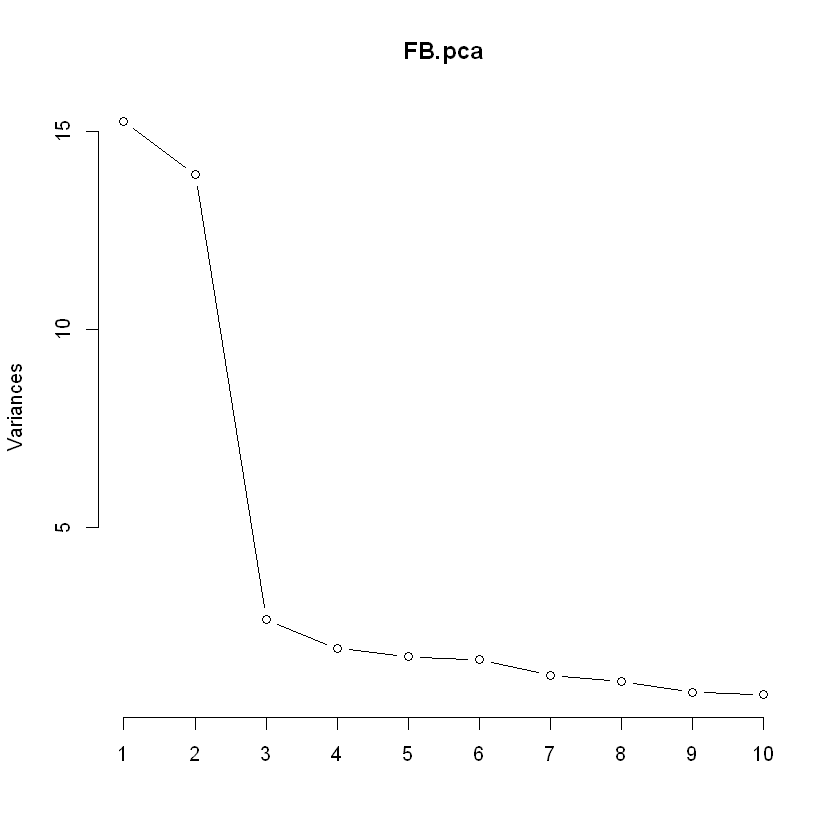

In [8]:
FB.hours <-FremontBridgePivot[, 3:49]
FB.pca <- prcomp(FB.hours,
    center = TRUE,
    scale = TRUE)
plot(FB.pca, type = "l")
summary(FB.pca)

Based on the hockey-stick shaped plot above, we see that the point at which the slope changes from vertical to horizontal is at around 3 principal components. Therefore we should look at PC1, PC2, and PC3. Additionally looking at the proportion of variance explaiend by these components, each of these is realitvely high (32%, 30% and 6%) as compared to the later components (which only goes as high as 4%).

# 6. More Visualizations and Conclusions

## (a)

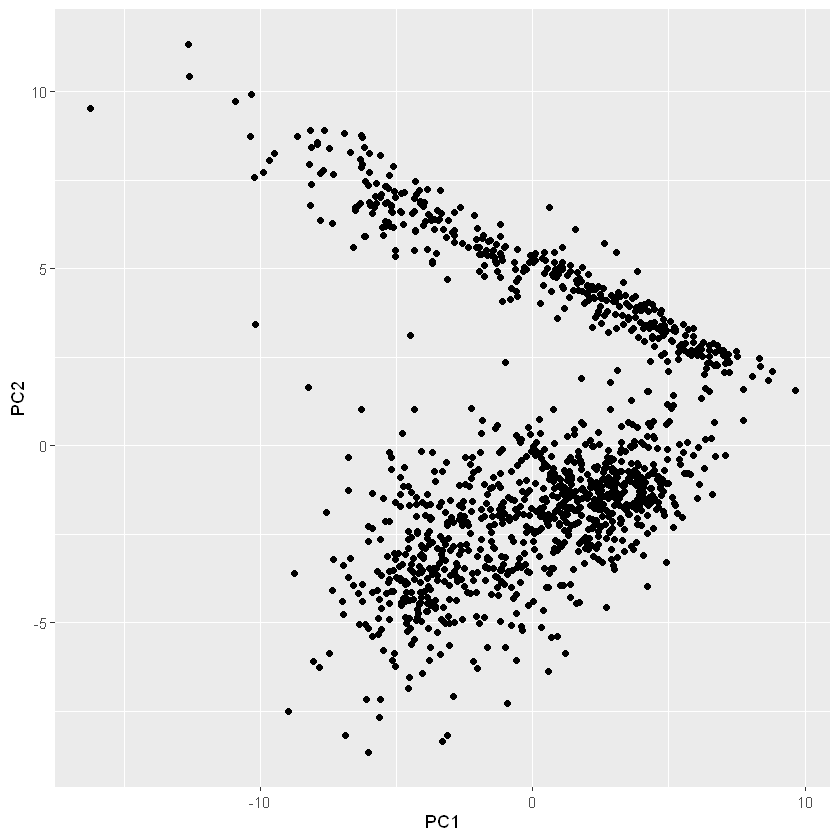

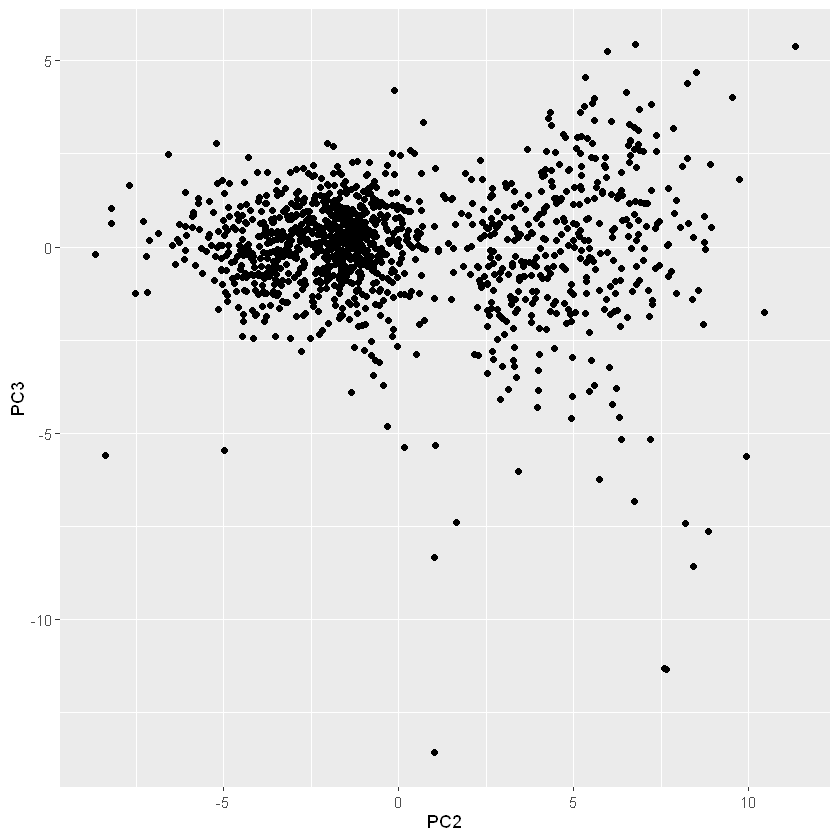

In [9]:
scores <- data.frame(FB.pca$x[,1:3])
ggplot(scores, aes(x=PC1, y=PC2)) + geom_point()
ggplot(scores, aes(x=PC2, y=PC3)) + geom_point()

## (b)

### 1. Color day of the week in different colors

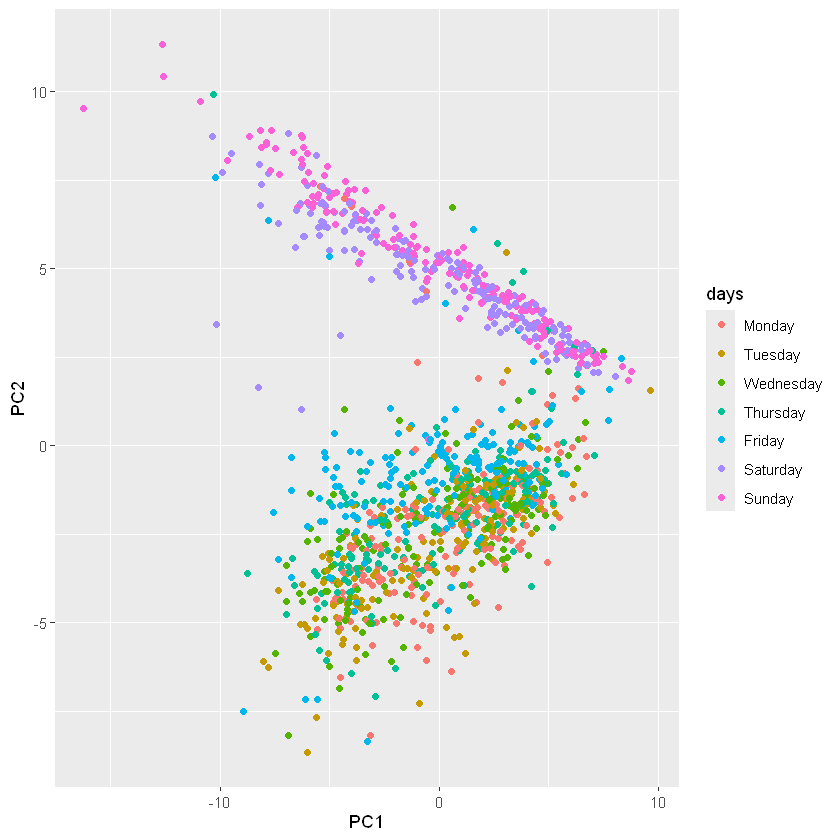

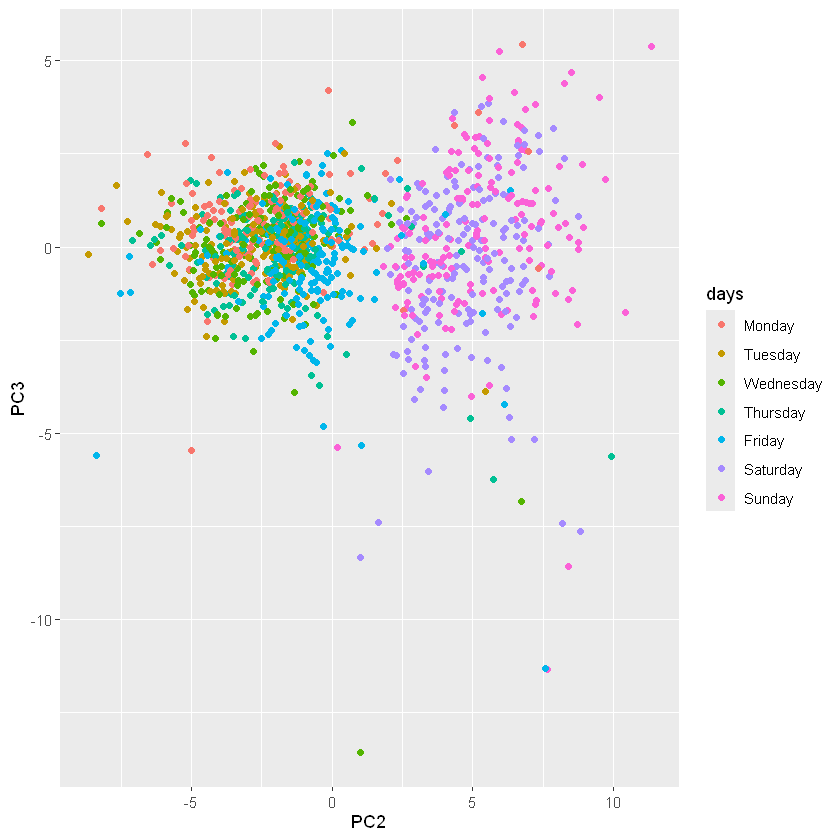

In [10]:
days = factor(weekdays(FremontBridgePivot$date), levels=c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))
ggplot(scores, aes(x=PC1, y=PC2, color=days)) + geom_point()
ggplot(scores, aes(x=PC2, y=PC3, color=days)) + geom_point()

### 2. Color weekdays vs weekend days differently

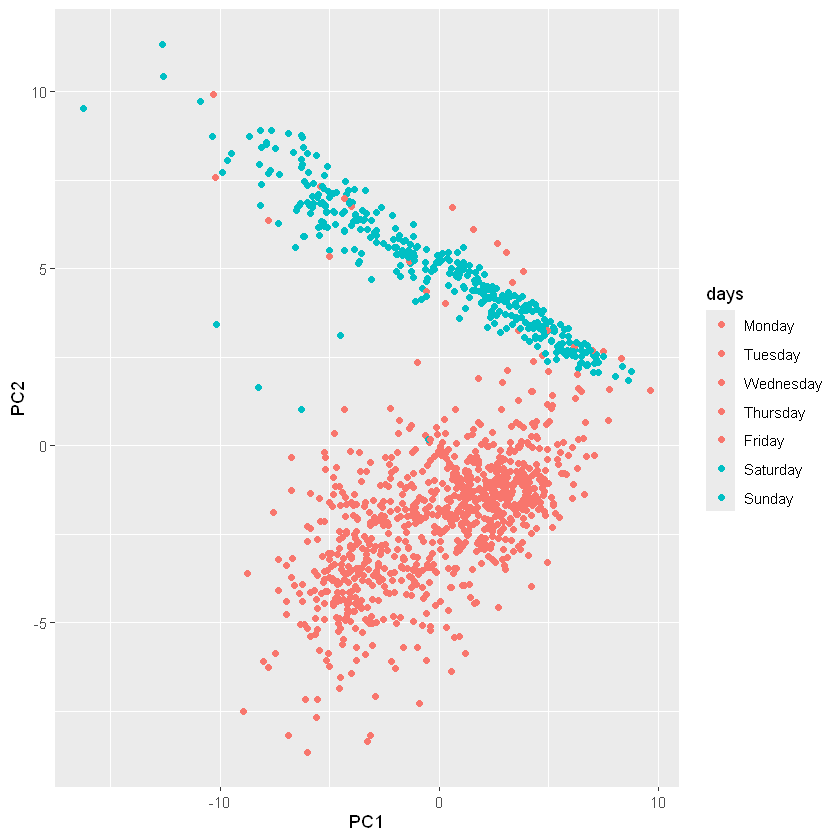

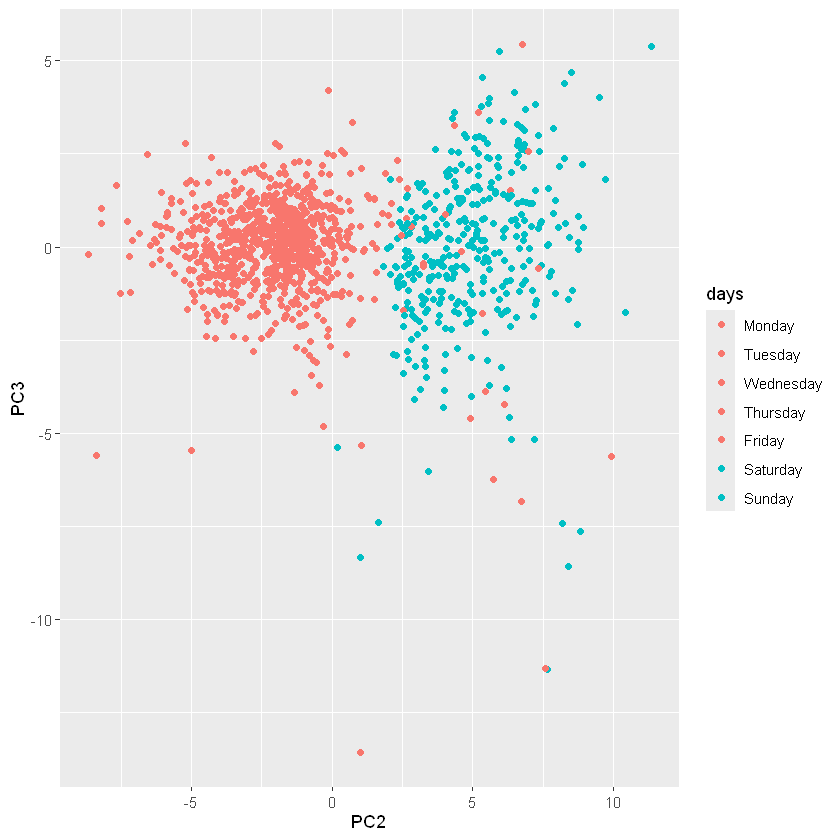

In [11]:
ggplot(scores, aes(x=PC1, y=PC2, color=days)) + geom_point() +
    scale_color_manual(values = c("Monday"=red,"Tuesday"=red,"Wednesday"=red,
                                   "Thursday"=red,"Friday"=red,"Saturday"=blue,"Sunday"=blue))
ggplot(scores, aes(x=PC2, y=PC3, color=days)) + geom_point() +
    scale_color_manual(values = c("Monday"=red,"Tuesday"=red,"Wednesday"=red,
                                   "Thursday"=red,"Friday"=red,"Saturday"=blue,"Sunday"=blue))

### 3. Find out holiday days and color these differently

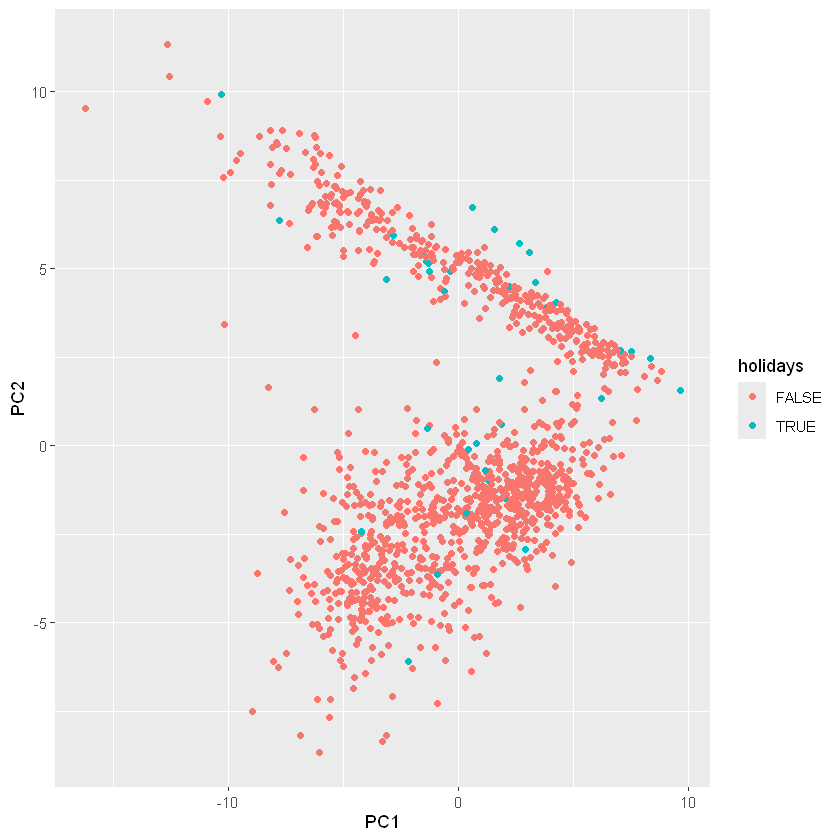

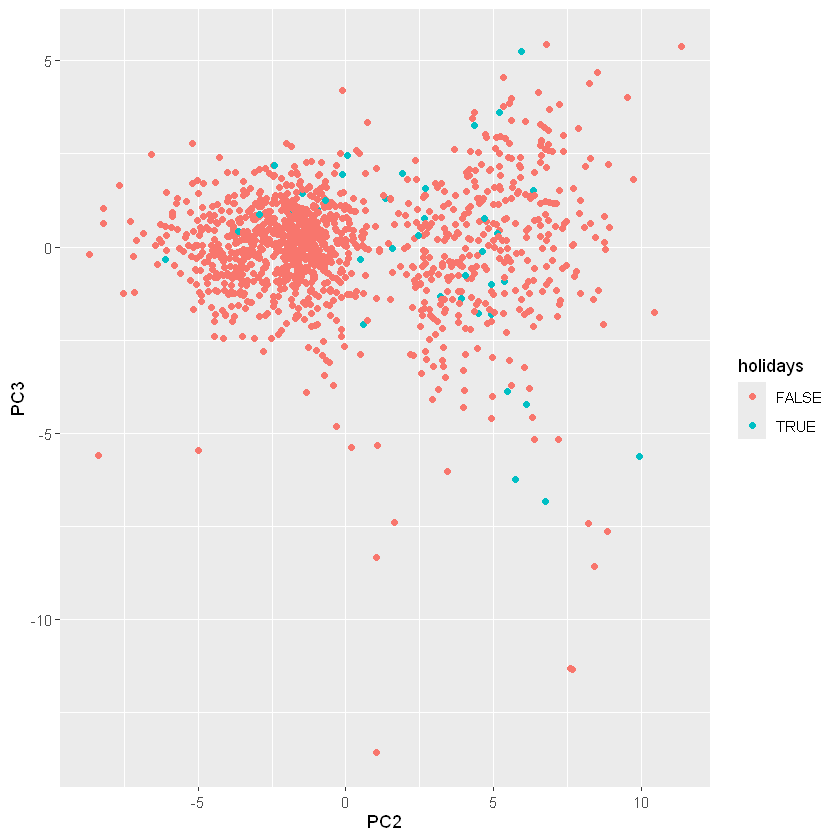

In [12]:
holidays = format(FremontBridgePivot$date, "%m/%d") %in% c(
  "01/01",  # New Year's Day
  "07/04",  # Independence Day
  "12/25",  # Christmas Day
  "01/20",  # Martin Luther King Jr. Day (approximate fixed date)
  "02/17",  # Presidents' Day (approximate fixed date)
  "05/25",  # Memorial Day (approximate fixed date)
  "09/07",  # Labor Day (approximate fixed date)
  "10/12",  # Columbus Day (approximate fixed date)
  "11/11",  # Veterans Day
  "11/26"   # Thanksgiving (approximate fixed date)
)
ggplot(scores, aes(x=PC1, y=PC2, color=holidays)) + geom_point()
ggplot(scores, aes(x=PC2, y=PC3, color=holidays)) + geom_point()

### 4. Color Fridays differently

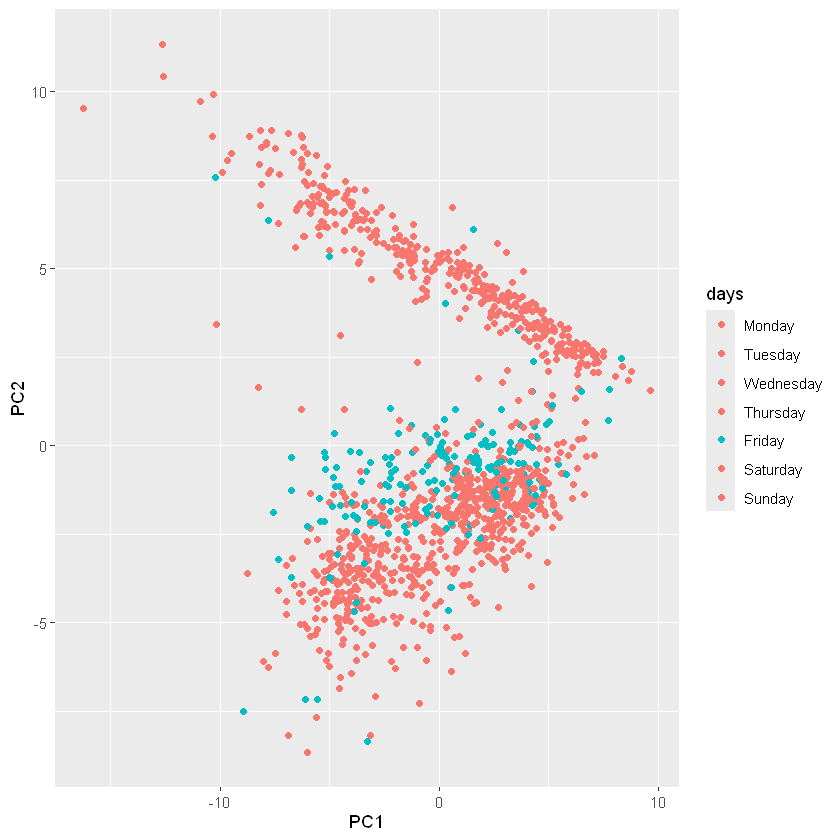

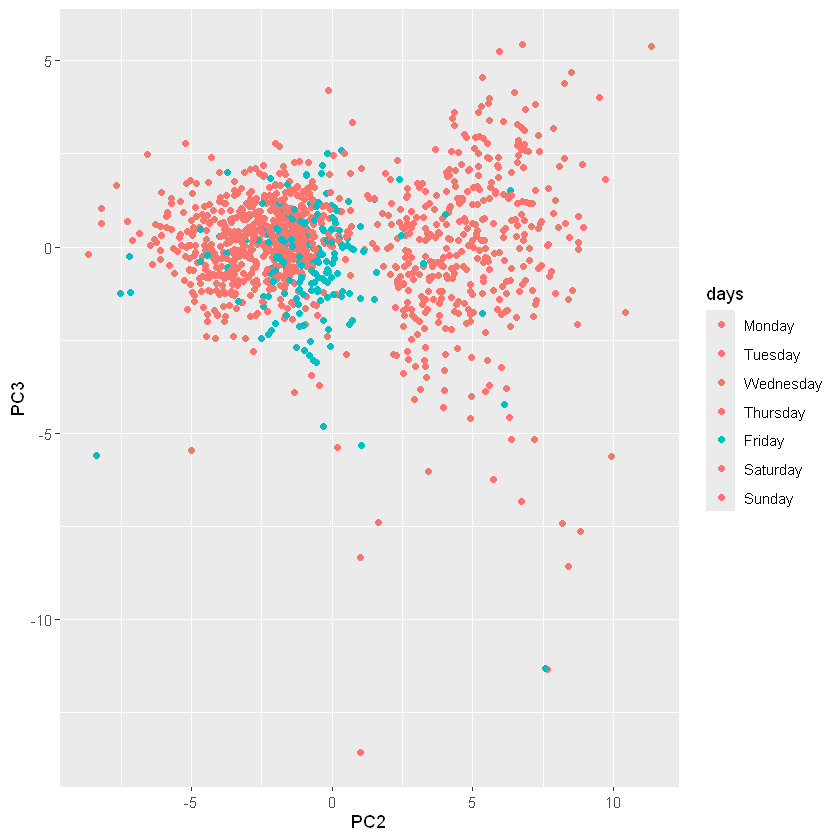

In [13]:
ggplot(scores, aes(x=PC1, y=PC2, color=days)) + geom_point() +
    scale_color_manual(values = c("Monday"=red,"Tuesday"=red,"Wednesday"=red,
                                   "Thursday"=red,"Friday"=blue,"Saturday"=red,"Sunday"=red))
ggplot(scores, aes(x=PC2, y=PC3, color=days)) + geom_point() +
    scale_color_manual(values = c("Monday"=red,"Tuesday"=red,"Wednesday"=red,
                                   "Thursday"=red,"Friday"=blue,"Saturday"=red,"Sunday"=red))